In [ ]:
#Importing the libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from IPython import display

In [10]:
import os
import pandas as pd

# Path to the directory containing images
base_dir = '/notebooks/cats_bigger_than_128x128'

# Get list of all image files
image_files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

# Create a DataFrame
df = pd.DataFrame({
    'filename': image_files,
    'class': ['cat'] * len(image_files)  # Assuming all images belong to the same class 'cat'
})

print(df.head())


           filename class
0  00000367_004.jpg   cat
1  00001150_013.jpg   cat
2  00000011_001.jpg   cat
3  00000850_000.jpg   cat
4  00000098_019.jpg   cat


In [1]:
pip install tensorRT

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorRT: filename=tensorrt-10.0.1-py2.py3-none-any.whl size=16332 sha256=ecde0148e0a99f4bcdf193fd0ffa238803d0ec8795b7e3ed1b8c7d08e91c73b7
  Stored in directory: /root/.cache/pip/wheels/31/90/ef/53ad98d9a1bd660c0177aa1ea91bde288edfbe4d15621ca472
  Created wheel for tensorrt-cu12: filename=tensorrt_cu12-10.0.1-py2.py3-none-any.whl size=17551 sha256=13cbaa50239db1e49ddb71544639ec1805e68e9d5d771e6e64c477996554d0d7
  Stored in directory: /root/.cache/pip/wheels/c5/08/30/a058eaf14eeeabb3799e3abd3a2a534649123824dcd9695876
Successfully built tensorRT tensorrt-cu12
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Generator architecture
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [ ]:
#Discriminator architecture
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#Model testing function
def generate_and_save_images(model, epoch, test_input):
    # Generate images from the model
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Scale images from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

In [ ]:
#Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs, steps_per_epoch):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        start_time = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch, image_batch in enumerate(dataset.take(steps_per_epoch)):
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
#            if batch % 10 == 0:  # Print progress every 10 batches
#                print(f'Epoch {epoch+1}, Batch {batch}: Training step completed')

        end_time = time.time()
        epoch_duration = end_time - start_time
        avg_gen_loss = total_gen_loss / steps_per_epoch
        avg_disc_loss = total_disc_loss / steps_per_epoch

  #      print(f'Time for epoch {epoch+1} is {epoch_duration:.2f} seconds, Generator loss: {avg_gen_loss}, Discriminator loss: {avg_disc_loss}')

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [ ]:
# Define model architecture
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
# Directory with images
base_dir = '/notebooks/cats_bigger_than_128x128'
image_files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) == 0:
    raise ValueError("No images found in the specified directory.")


In [ ]:
# Create DataFrame with image file names and class labels
df = pd.DataFrame({
    'filename': image_files,
    'class': ['cat'] * len(image_files)  # Assuming all images belong to the same class 'cat'
})

print(df.head())


In [ ]:
# Data generator parameters
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Create data generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    df,
    directory=base_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb'
)


In [ ]:
# Convert the generator to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [ ]:
# Calculate steps_per_epoch
steps_per_epoch = len(image_files) // BATCH_SIZE

In [ ]:
# Profiling setup
tf.profiler.experimental.start('logdir')

In [ ]:
# Train the model
train(train_dataset, epochs=250, steps_per_epoch=steps_per_epoch)

In [ ]:
# Stop the profiler after training
tf.profiler.experimental.stop()

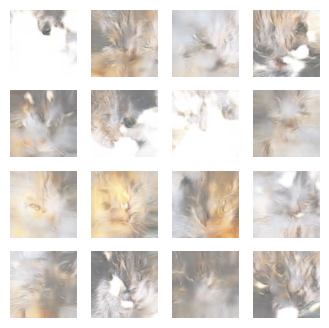

2024-05-18 01:24:35.612956: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.


In [ ]:
#Same as the cells above but all compiled together with a more sophisticated
#DCGAN architecture
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from IPython import display

# Define improved Generator architecture
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((16, 16, 512)))
    assert model.output_shape == (None, 16, 16, 512)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

# Define improved Discriminator architecture
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Scale images from [-1, 1] to [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs, steps_per_epoch):
    seed = tf.random.normal([16, 100])
    for epoch in range(epochs):
        start_time = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        
        for batch, image_batch in enumerate(dataset.take(steps_per_epoch)):
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss

        end_time = time.time()
        epoch_duration = end_time - start_time
        avg_gen_loss = total_gen_loss / steps_per_epoch
        avg_disc_loss = total_disc_loss / steps_per_epoch

        print(f'Time for epoch {epoch+1} is {epoch_duration:.2f} seconds, Generator loss: {avg_gen_loss}, Discriminator loss: {avg_disc_loss}')

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

# Directory with images
base_dir = '/notebooks/cats_bigger_than_128x128'
image_files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

# Check if there are images in the directory
if len(image_files) == 0:
    raise ValueError("No images found in the specified directory.")

df = pd.DataFrame({
    'filename': image_files,
    'class': ['cat'] * len(image_files)  # Assuming all images belong to the same class 'cat'
})

print(df.head())

# Data generator parameters
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Include data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_dataframe(
    df,
    directory=base_dir,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    color_mode='rgb'
)

# Convert the generator to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Calculate steps_per_epoch
steps_per_epoch = len(image_files) // BATCH_SIZE

# Profiling setup
tf.profiler.experimental.start('logdir')

# Train the model
train(train_dataset, epochs=250, steps_per_epoch=steps_per_epoch)

# Stop the profiler after training
tf.profiler.experimental.stop()


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Define the number of epochs
epochs = 5  # or the number of epochs you used for training

# Use the trained model to generate new images
seed = tf.random.normal([16, 100])
generate_and_save_images(generator, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i].numpy() * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Define the number of epochs
epochs = 50  # or the number of epochs you used for training

# Use the trained model to generate new images
seed = tf.random.normal([16, 100])
generate_and_save_images(generator, epochs, seed)


In [ ]:
generator.save('cat_generator_model-250epochs.h5')
